# Employee Attrition Prediction with XAI

The goal of this notebook is to perform an Exploratory Data Analysis (EDA) to understand the structure and quality of the dataset before training any model. We will focus on:

* **Data Quality:** Identifying missing values, duplicates, and constant columns.
* **Target Analysis:** Understanding the class imbalance in `Attrition`.

### About Dataset

Uncover the factors that lead to employee attrition and explore important questions such as ‘show me a breakdown of distance from home by job role and attrition’ or ‘compare average monthly income by education and attrition’. This is a fictional data set created by IBM data scientists.

| | <small>Education</small> | <small>EnvironmentSatisfaction</small> | <small>JobInvolvement</small> | <small>JobSatisfaction</small> | <small>PerformanceRating</small> | <small>RelationshipSatisfaction</small> | <small>WorkLifeBalance</small> |
|---|---|---|---|---|---|---|---|
| 1 | <small>'Below College'</small> | <small>'Low'</small> | <small>'Low'</small> | <small>'Low'</small> | <small>'Low'</small> | <small>'Low'</small> | <small>'Bad'</small> |
| 2 | <small>'College'</small> | <small>'Medium'</small> | <small>'Medium'</small> | <small>'Medium'</small> | <small>'Good'</small> | <small>'Medium'</small> | <small>'Good'</small> |
| 3 | <small>'Bachelor'</small> | <small>'High'</small> | <small>'High'</small> | <small>'High'</small> | <small>'Excellent'</small> | <small>'High'</small> | <small>'Better'</small> |
| 4 | <small>'Master'</small> | <small>'Very High'</small> | <small>'Very High'</small> | <small>'Very High'</small> | <small>'Outstanding'</small> | <small>'Very High'</small> | <small>'Best'</small> |
| 5 | <small>'Doctor'</small> | - | - | - | - | - | - |


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración visual para gráficos profesionales
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
pd.set_option('display.max_columns', None) # Para ver todas las columnas

# Cargar datos
try:
    df = pd.read_csv('../data/raw_employee_attrition.csv')
    print("✅ Dataset loaded successfully.")
    print(f"Dimensions: {df.shape[0]} rows, {df.shape[1]} columns")
except FileNotFoundError:
    print("❌ Error: File not found. Check the path.")

df.head()

✅ Dataset loaded successfully.
Dimensions: 1470 rows, 35 columns


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


## 1. Data Quality Inspection

We check for null values and identify "useless" columns.
* **Constant Columns:** Features with 0 variance (same value for everyone).
* **ID Columns:** Identifiers with no predictive power.

In [8]:
# 1. Null check
print(f"Total Missing Values: {df.isnull().sum().sum()}")

# 2. Identify Constant Columns (1 unique value)
constant_cols = [col for col in df.columns if df[col].nunique() == 1]

# 3. Identify ID columns (All values are unique)
# We exclude 'EmployeeNumber' explicitly as it's a known ID
id_cols = ['EmployeeNumber'] if 'EmployeeNumber' in df.columns else []

print(f"⚠️ Constant Columns to drop: {constant_cols}")
print(f"⚠️ ID Columns to drop: {id_cols}")

# Create clean dataframe
df_clean = df.drop(columns=constant_cols + id_cols)
print(f"Dimensions after cleaning: {df_clean.shape}")

Total Missing Values: 0
⚠️ Constant Columns to drop: ['EmployeeCount', 'Over18', 'StandardHours']
⚠️ ID Columns to drop: ['EmployeeNumber']
Dimensions after cleaning: (1470, 31)


## 2. Target Variable Analysis (Attrition)

Understanding the distribution of the target variable is crucial to identify **imbalance**, which will dictate our modeling strategy (e.g., using F1-Score instead of Accuracy).

Attrition Rate: 16.1%


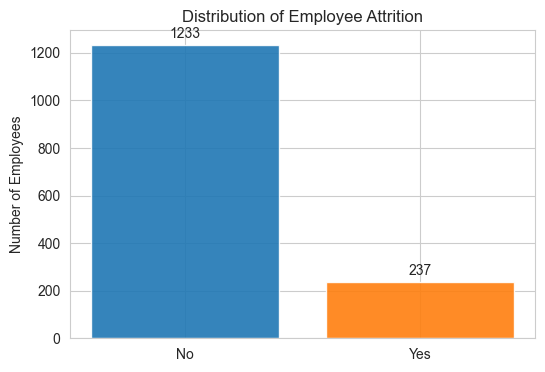

In [9]:
# Preparar datos
attrition_counts = df_clean['Attrition'].value_counts()
colors = ['#1f77b4', '#ff7f0e'] # Azul (No/Stay), Naranja (Yes/Leave)

# Plot
fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(attrition_counts.index, attrition_counts.values, color=colors, alpha=0.9)

# Añadir etiquetas
ax.bar_label(bars, fmt='%d', padding=3)
ax.set_title('Distribution of Employee Attrition')
ax.set_ylabel('Number of Employees')

# Calcular porcentaje
ratio = attrition_counts['Yes'] / attrition_counts.sum()
print(f"Attrition Rate: {ratio:.1%}")
plt.show()

## 3. Correlation Analysis (Multicollinearity Check)

We analyze the correlation between numerical features to identify redundant variables.
* **Goal:** Identify pairs of features with high correlation that carry the same information. Removing these redundancies improves model stability and explainability.

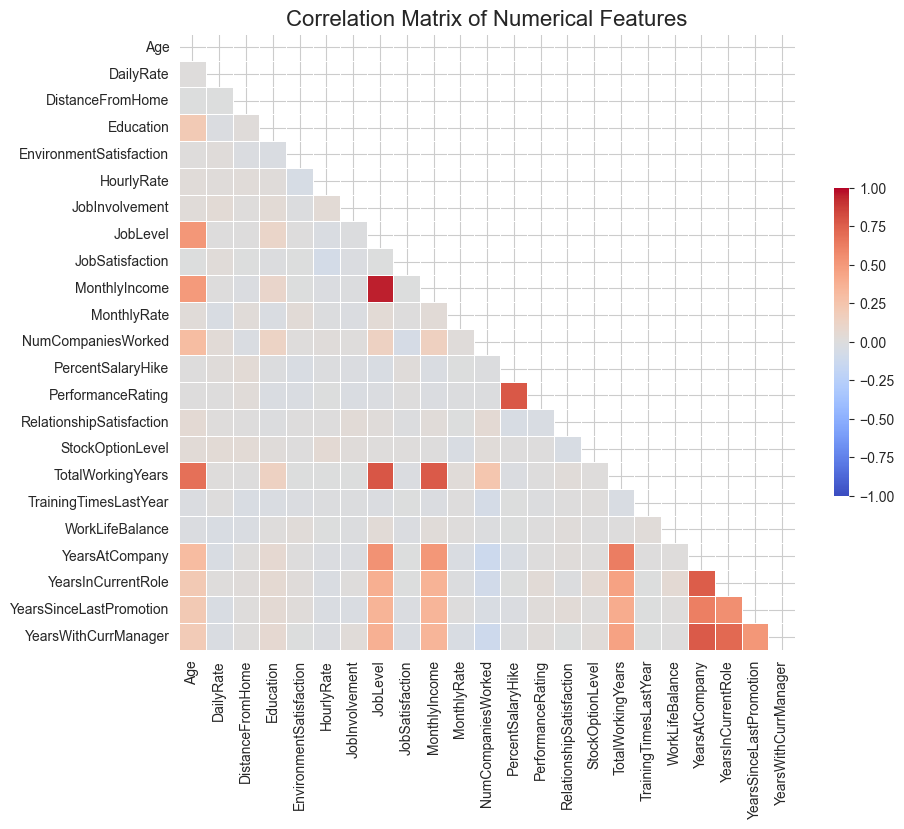

--- 🔍 Highly Correlated Pairs (Threshold > 0.7) ---
🔗 MonthlyIncome <--> JobLevel: 0.95
🔗 TotalWorkingYears <--> JobLevel: 0.78
🔗 PerformanceRating <--> PercentSalaryHike: 0.77
🔗 TotalWorkingYears <--> MonthlyIncome: 0.77
🔗 YearsWithCurrManager <--> YearsAtCompany: 0.77
🔗 YearsInCurrentRole <--> YearsAtCompany: 0.76
🔗 YearsWithCurrManager <--> YearsInCurrentRole: 0.71


In [11]:
# 1. Select Numerical Columns
# We only analyze numeric features for correlation
numeric_df = df_clean.select_dtypes(include=[np.number])

# 2. Calculate Correlation Matrix
corr_matrix = numeric_df.corr()

# 3. Plot Heatmap
plt.figure(figsize=(10, 8))
# Mask to hide the upper triangle (since it's symmetric)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap='coolwarm',
    vmax=1,
    vmin=-1,
    center=0,
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": .5},
    annot=False # Set to True if you want to see the numbers in the grid
)
plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.show()

# 4. List High Correlations (The "Redundancy Detector")
# This helps us decide which features to drop in the next step
print("--- 🔍 Highly Correlated Pairs (Threshold > 0.7) ---")
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        # We check absolute correlation
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            colname_i = corr_matrix.columns[i]
            colname_j = corr_matrix.columns[j]
            score = corr_matrix.iloc[i, j]
            high_corr_pairs.append((colname_i, colname_j, score))

# Sort by strength (descending)
high_corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

for col_i, col_j, score in high_corr_pairs:
    print(f"🔗 {col_i} <--> {col_j}: {score:.2f}")